# Τεχνητή Νοημοσύνη: Ενότητα 1

    

---



Ο στόχος της εργασίας είναι η εφαρμογή αλγορίθμων αναζήτησης και εύρεσης καλύτερου μονοπατιού σε λαβύρινθο διαστάσεων $N\times N$

Σκοπός του μέρους Α της άσκησης  είναι η υλοποίηση αλγορίθμων αναζήτησης και ανάκτησης της καλύτερης διαδρομής σε έναν λαβύρινθο διάστασης Ν×Ν. Σας ζητείται να υλοποιήσετε διάφορους αλγορίθμους για την εύρεση συντομότερων μονοπατιών και να κατασκευάσετε διάφορες συναρτήσεις κόστους τόσο για τη μέτρηση πραγματικών αποστάσεων όσο και για την εκτίμηση των αποστάσεων από έναν κόμβο προς τον κόμβο-στόχο (ευρετικές μέθοδοι). Μπορείτε επίσης να πειραματιστείτε με οποιαδήποτε από τις παραμέτρους κάθε αλγορίθμου, προκειμένου να μελετήσετε πώς οι αλλαγές αυτές επηρεάζουν την πολυπλοκότητα, το χρόνο καθώς και τη βέλτιστη διαδρομή. Οι προτεινόμενοι αλγόριθμοι καθώς και οι παραλλαγές τους θα εκτελεστούν σε λαβύρινθους διαφορετικών μεγεθών. Οι αλγόριθμοι θα συγκριθούν με βάση την πολυπλοκότητά τους και κατά πόσο μπορούν να βρουν τη βέλτιστη διαδρομή. Τέλος, στον λαβύρινθο υπάρχει ένα φάντασμα! Ο στόχος είναι Να φτάσουμε στο σημείο τερματισμού αποφεύγοντας το φάντασμα, το οποίο μας κυνηγάει τρέχοντας στη μέση του λαβύρινθου εκτελώντας το δικό του Α* σε κάθε βήμα!

---

## Visualization Code

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import PillowWriter
from IPython.display import HTML

class visualization:
    def __init__(self, S, F):
        '''
          This method initializes an object of type visualization.
          Input:
          -> S: the starting point of the search
          -> F: the end point
        '''
        self.S = S
        self.F = F
        self.images = []

    def draw_step(self, grid, frontier, expanded_nodes):
        '''
          This function is called to draw a frame in the animation (practically after each node is expanded)
          Input:
          -> grid: a map of type grid
          -> frontier: A list of nodes belonging to the search front
          -> expanded_nodes: a list of nodes that have already been expanded
          Returns: None
          This function must be called at least once before an animation can be drawn (the animation must have at least one frame).
        '''
        image = np.zeros((grid.N, grid.N, 3), dtype=int)
        image[~grid.grid] = [0, 0, 0]
        image[grid.grid] = [255, 255, 255]
        # Use this to treat 1/True as obstacles
        # image[grid.grid] = [0, 0, 0]
        # image[~grid.grid] = [255, 255, 255]

        for node in expanded_nodes:
            image[node] = [0, 0, 128]

        for node in frontier:
            image[node] = [0, 225, 0]

        image[self.S] = [50, 168, 64]
        image[self.F] = [168, 50, 50]
        self.images.append(image)

    def add_path(self, path):
        '''
          This function adds the optimal path to the last frame.
          Input:
          -> path: a list containing the optimal path (which must contain both the start node and the target node)
          Output: None
        '''
        for n in path[1:-1]:
            image = np.copy(self.images[-1])
            image[n] = [66, 221, 245]
            self.images.append(image)
        for _ in range (100):
            self.images.append(image)

    def create_gif(self, fps = 30, repeat_delay = 2000):
        if len(self.images) == 0:
            raise EmptyStackOfImages("Error! You have to call 'draw_step' at  first.")
        fig = plt.figure()
        plt.axis('off')
        ims = []
        for img in self.images:
            img = plt.imshow(img)
            ims.append([img])
        ani = animation.ArtistAnimation(fig, ims, interval=1000//fps, blit=True, repeat_delay= repeat_delay)
        plt.close(fig)
        return ani

    def save_gif(self, filename, fps = 30):
        '''
            This function recreates and saves the animation to a file.
            Input:
            -> The filename with the extension .gif
            Output: (None)
        '''
        ani = self.create_gif(fps)
        writer = PillowWriter(fps= fps)
        ani.save(filename, writer=writer)

    def show_gif(self, fps= 30, repeat_delay = 2000):
        '''
            This function displays the animation inline.
            Input:
            -> fps: frames per second
            Output: the object playing the animation
            Exceptions: EmptyStackOfImages if the animation has not a single frame, i.e. if draw_step has never been called.
        '''
        ani = self.create_gif(fps, repeat_delay)
        # return HTML(ani.to_html5_video())
        return HTML(ani.to_jshtml())

    def show_last_frame(self):
        '''
            This method displays inline the last frame created.
            Input:
            Output: the object that displays the frame.
            Exceptions: EmptyStackOfImages if the animation has not a single frame, i.e. if draw_step has never been called.
        '''
        if len(self.images) == 0:
            raise EmptyStackOfImages("Error! You have to call 'draw_step' at  first.")
        else:
            plt.imshow(self.images[-1])


class EmptyStackOfImages(Exception):
    pass



---



## Μέρος 1


---


Ο στόχος του πρώτου μέρους είναι η κατασκευή **λαβυρίνθων**. [Σε αυτό το άρθρο της Wikipedia](https://en.wikipedia.org/wiki/Maze_generation_algorithm) μπορείτε να βρείτε διάφορους αλγορίθμους για αυτό το σκοπό, συμπεριλαμβανομένου κι αυτού που χρησιμοποιείται παρακάτω. Προσέξτε ότι οι αλγόριθμοι του παραπάνω άρθρου κατασκευάζουν ένα μόνο μονοπάτι από κάθε σημείο του λαβυρίνθου προς οποιοδήποτε άλλο (η δομή του λαβυρίνθου έχει μορφή συνεκτικού δέντρου). Καλείστε να συμπληρώσετε τον κώδικα στα σημεία που λείπει ώστε οι λαβύρινθοι που κατασκευάζει τυχαία να έχουν μεταβλητή πυκνότητα εμποδίων/τοίχων (καθορίζεται από την παράμετρο threshold). Όλοι οι χάρτες θα πρέπει να έχουν τουλάχιστον ένα μονοπάτι μεταξύ ενός σημείου αφετηρίας (S) και ενός σημείου τερματισμού (F).

Σε όλα τα ερωτήματα φροντίστε να χρησιμοποιήσετε **δομημένο** κώδικα, με **σχόλια** που επισημαίνουν τη λογική του.


### Παραδείγματα λαβυρίνθων



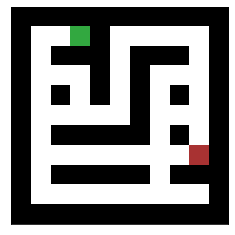
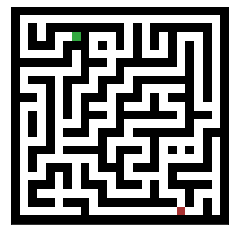
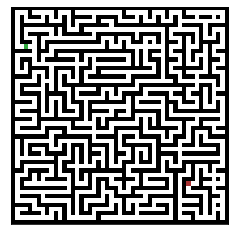

In [67]:
%matplotlib inline
import numpy as np
from queue import LifoQueue
import  random
import matplotlib.pyplot as plt


class Maze:
    def __init__(self, N, S, F, threshold=0.02):

      """
      N: integer that indicates the size of the NxN grid of the maze
      S: pair of integers that indicates the coordinates of the starting point (S)
      F: pair of integers that indicates the coordinates of the finish point (F)
      You can add any other parameters you want to customize maze creation (e.g. variables that
      control the creation of additional paths)
      """

      assert N > 2

      ## Make sure start and end are within the grid

      assert S < (N-1, N-1)
      assert F < (N-1, N-1)

      assert S > (0, 0)
      assert F > (0, 0)

      # Add here any additional constraints your implementation may have

      self.N = N
      self.S = S
      self.F = F

      # Keep track of the agents in the Maze
      self.agents=[]

      ## Initialize grid

      self.grid = np.zeros((N, N), dtype=bool)

      def neighbors(node, N, visited, threshold):
        """
        Returns all neighbors of a node that are either unvisited, or they are visited but
        there is a wall between the node and the neighbor and the neighbor passes a random test.
        """

        l = []
        x, y = node

        # first condition in all checks is for boundaries
        # neighbors are +-2 in x or y
        # walls are +-1

        if x > 2 and (not visited[x-2, y] or (not visited[x-1,y] and random.uniform(0,1) <= threshold)):
            l.append((x-2, y))

        ### ### ### ### ### ###
        ### YOUR CODE HERE \/

        if x > 1 and (not visited[x-2, y] or (visited[x-1, y] and random.random() <= threshold)):
            l.append((x-2, y))
        if x < N - 2 and (not visited[x+2, y] or (visited[x+1, y] and random.random() <= threshold)):
            l.append((x+2, y))
        if y > 1 and (not visited[x, y-2] or (visited[x, y-1] and random.random() <= threshold)):
            l.append((x, y-2))
        if y < N - 2 and (not visited[x, y+2] or (visited[x, y+1] and random.random() <= threshold)):
            l.append((x, y+2))

        ### YOUR CODE HERE /\
        ### ### ### ### ### ###
        return l

      stack = []
      stack.append(self.S)
      self.grid[self.S] = True

      while stack:
          current_node = stack.pop()
          # get all unvisited neighbors (and some visited ones with a random chance)
          n = neighbors(current_node, self.N, self.grid, threshold)
          if len(n):
              stack.append(current_node)

              ### ### ### ### ### ###
              ### YOUR CODE HERE \/

              next_node = random.choice(n)  # Select a random neighbor

              # Break the wall between current_node and next_node
              wall_x = (current_node[0] + next_node[0]) // 2
              wall_y = (current_node[1] + next_node[1]) // 2
              self.grid[wall_x, wall_y] = True

              # Mark next node as visited and add it to the stack
              self.grid[next_node] = True
              stack.append(next_node)

              ### YOUR CODE HERE /\
              ### ### ### ### ### ###

              # mark next node as visited and add it to the stack
              self.grid[next_node] = True
              stack.append(next_node)



    def adjacent_no_walls(self, node):
      x, y = node
      ret = []
      if x - 1 > -1 and self.grid[x-1,y]:
        ret.append((x-1,y))
      if x + 1 < self.N and self.grid[x+1,y]:
        ret.append((x+1,y))
      if y - 1 > -1 and self.grid[x,y-1]:
        ret.append((x,y-1))
      if y + 1 < self.N and self.grid[x,y+1]:
        ret.append((x,y+1))
      return ret



    def draw_map(self, path=None,return_image=False):
        """
        Draws the maze as an image. Considers grid values of 0/False to represent obstacles and
        values of 1/True to represent empty cells, but this can be customized. Obstacles are painted
        black and empty cells are painted white. Starting point is painted green and finish point red.
        Optionally accepts as a parameter a path within the maze which is painted blue.
        """
        image = np.zeros((self.N, self.N, 3), dtype=int)
        image[~self.grid] = [0, 0, 0]
        image[self.grid] = [255, 255, 255]
        # Use this to treat 1/True as obstacles
        # image[self.grid] = [0, 0, 0]
        # image[~self.grid] = [255, 255, 255]

        image[self.S] = [50, 168, 64]
        image[self.F] = [168, 50, 50]
        if path:
            for n in path[1:-1]:
                image[n] = [66, 221, 245]

        if len(self.agents)>0:
          for a in self.agents:
            image[a.location]=a.color

        if return_image:
          return image
        else:
          plt.imshow(image)
          plt.xticks([])
          plt.yticks([])
          plt.show()


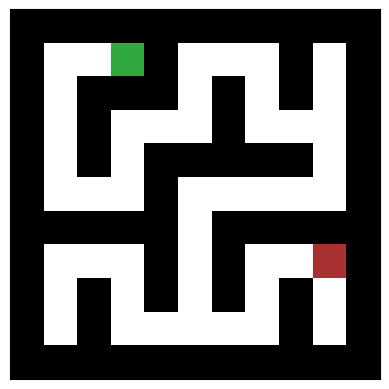

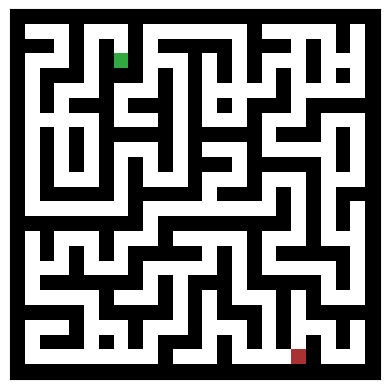

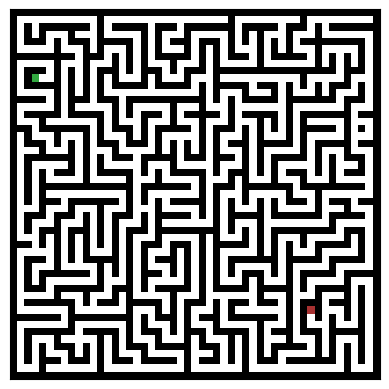

In [5]:
for N, S, F in (11, (1, 3), (7, 9)), (25, (3, 7), (23, 19)), (51, (9, 3), (41, 41)):
    map = Maze(N, S, F, threshold=2/(N*np.log(N)))
    map.draw_map()



---



## Μέρος 2


---



Στο δεύτερο μέρος της εργασίας καλείστε να υλοποιήσετε διάφορους αλγορίθμους εύρεσης συντομότερων μονοπατιών μεταξύ δυο κόμβων για τους λαβυρίνθους που παράγονται από τον κώδικα του πρώτου μέρους. Παράλληλα καλείστε να κατασκευάσετε και διάφορες συναρτήσεις κόστους τόσο για την μέτρηση των πραγματικών αποστάσεων όσο και για την εκτίμηση των αποστάσεων από έναν κόμβο στον κόμβο στόχο (heuristic). Επίσης μπορείτε να πειραματιστείτε με οποιαδήποτε από τις παραμέτρους κάθε αλγορίθμου με σκοπό να μελετήσετε το πώς οι αλλαγές αυτές επηρεάζουν την πολυπλοκότητα, τον χρόνο καθώς και βέλτιστο μονοπάτι. Οι παραπάνω αλγόριθμοι καθώς και οι παραλλαγές τους θα τρέξουν σε λαβυρίνθους με διαφορετικά μεγέθη. Υλοποιήστε τους αλγορίθμους στο κελί κώδικα του Μέρους 2.<br>

Η γενική μορφή της συνάρτησης κόστους στον αλγόριθμο Α* είναι:
$$f(n)=g(n)+h(n)$$
Παραπάνω, η συνάρτηση $g(n)$ δίνει την πραγματική απόσταση από το σημείο εκκίνησης μέχρι τον κόμβο $n$, και η συνάρτηση $h(n)$ αποτελεί μια ευριστική της απόστασης από τον κόμβο $n$ μέχρι τον στόχο. Σας ζητείται να πειραματιστείτε με τις εξής επιλογές για τις δύο συναρτήσεις:
* $g(n)=0$ και $h(n)=\{\text{manhattan}(n),\text{euclidean}(n)\}$. Ποιος αλγόριθμος αναζήτησης προκύπτει; Μπορεί να βρει πάντα το βέλτιστο μονοπάτι;
* $g(n)=1$ και $h(n)=0$. Ποιος αλγόριθμος αναζήτησης προκύπτει; Μπορεί να βρει πάντα το βέλτιστο μονοπάτι;
* $g(n)=1$ και $h(n)=\{\text{manhattan}(n),\text{euclidean}(n)\}$. Ποιος αλγόριθμος αναζήτησης προκύπτει; Μπορεί να βρει πάντα το βέλτιστο μονοπάτι;

Μπορείτε να προτείνετε και άλλες ευριστικές συναρτήσεις εκτός από τις αποστάσεις manhattan και euclidean;

In [6]:
from queue import PriorityQueue

class pathfinder:
    def __init__(self, S, F, grid, c, h, visualize=True, vis=None):
        self.S = S
        self.F = F
        self.grid = grid
        self.cost = c
        self.heuristic = h
        self.no_expanded_nodes = 0

        # Visualization settings
        self.visualize = visualize
        # Check if an external visualization instance is passed
        if self.visualize:
            self.vis = vis if vis else visualization(S, F)

        self.find_path()

    def find_path(self):
        frontier = PriorityQueue()
        frontier.put((0, self.S))
        came_from = {self.S: None}
        cost_so_far = {self.S: 0}
        self.no_expanded_nodes = 0

        while not frontier.empty():
            current = frontier.get()[1]

            # Visualization: Draw current state before proceeding
            if self.visualize:
                current_frontier = [node[1] for node in frontier.queue]
                self.vis.draw_step(self.grid, current_frontier, list(came_from.keys()))

            if current == self.F:
                # If we reach the goal, finalize path visualization and exit loop
                if self.visualize:
                    self.vis.add_path(self.reconstruct_path(came_from, current))
                break

            self.no_expanded_nodes += 1

            for next in self.grid.adjacent_no_walls(current):
                new_cost = cost_so_far[current] + self.cost(current, next)
                if next not in cost_so_far or new_cost < cost_so_far[next]:
                    cost_so_far[next] = new_cost
                    priority = new_cost + self.heuristic(next, self.F)
                    frontier.put((priority, next))
                    came_from[next] = current

        self.path = self.reconstruct_path(came_from, current)

    def reconstruct_path(self, came_from, current):
        # Build the path by following backlinks from the goal to the start
        path = []
        while current != self.S:
            path.append(current)
            current = came_from[current]
        path.append(self.S)
        path.reverse()
        return path

    def get_path(self):
        return self.path

    def get_complexity(self):
        return self.no_expanded_nodes

    def save_gif(self, filename):
        if self.visualize:
            self.vis.save_gif(filename)
        else:
            raise ValueError("Visualization was not enabled, so no GIF can be saved.")

In [7]:
import math

## Define heuristics
def euclidean(a, b):
    return math.sqrt((a[0] - b[0])**2 + (a[1] - b[1])**2)

### ### ### ### ### ###
### YOUR CODE HERE \/

def manhattan(a, b):
    return abs(a[0] - b[0]) + abs(a[1] - b[1])

### YOUR CODE HERE /\
### ### ### ### ### ###

**Παραλλαγές του Α***

1. $g(n)=0$ και $h(n)=\{\text{manhattan}(n),\text{euclidean}(n)\}$.
   - **Αποτέλεσμα**: πρόκειται για την **Greedy Best-First Search**. Εδώ, ο αλγόριθμος επιλέγει τον κόμβο που είναι ευρετικά πιο κοντά στο στόχο, αγνοώντας το κόστος για να φτάσει κανείς σε αυτόν τον κόμβο από την αρχή.
   - **Ορθότητα**: ο αλγόριθμος δεν βρίσκει πάντα τη βέλτιστη διαδρομή, επειδή μπορεί να παραπλανηθεί από την ευρετική - μπορεί να ευνοήσει κόμβους που φαίνονται κοντά στο στόχο χωρίς να λάβει υπόψη το συνολικό κόστος ταξιδιού.

2. $g(n)=1$ και $h(n)=0$.
   - **Αποτέλεσμα**: πρόκειται για τον **Αλγόριθμο του Dijkstra**. Εδώ, η αναζήτηση επεκτείνει τους κόμβους με βάση την απόστασή τους από την αρχή, αγνοώντας πλήρως κάθε ευρετική καθοδήγηση.
   - **Ορθότητα**: ο αλγόριθμος βρίσκει πάντα τη βέλτιστη διαδρομή, επειδή εξερευνά συστηματικά τη λιγότερο δαπανηρή διαθέσιμη διαδρομή μέχρι να φτάσει στο στόχο.

3.  $g(n)=1$ και $h(n)=\{\text{manhattan}(n),\text{euclidean}(n)\}$.
   - **Αποτέλεσμα**: πρόκειται για τον τυπικό **Α* Αλγόριθμο αναζήτησης**. Λαμβάνει υπόψη τόσο το πραγματικό κόστος για την επίτευξη ενός κόμβου όσο και μια ευρετική εκτίμηση της απόστασης από τον κόμβο στον στόχο.
   - **Ορθότητα**: ο αλγόριθμος βρίσκει πάντα τη βέλτιστη διαδρομή, εφόσον η ευρετική συνάρτηση είναι αποδεκτή (δεν υπερεκτιμά ποτέ το πραγματικό κόστος).



In [8]:
## Create a 41x41 maze
N = 41
S = (5, 9)
F = (37, 37)

map = Maze(N, S, F)

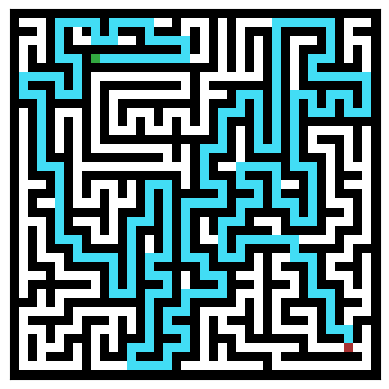

CPU times: user 273 ms, sys: 44.1 ms, total: 317 ms
Wall time: 291 ms


In [9]:
%%time
## Find and visualize the path
pf = pathfinder(S, F, map, lambda x, y: 1, lambda x, y: 0)
map.draw_map(pf.get_path())

In [10]:
expanded_nodes = pf.get_complexity()
print('Number of expanded nodes:', expanded_nodes)

Number of expanded nodes: 679


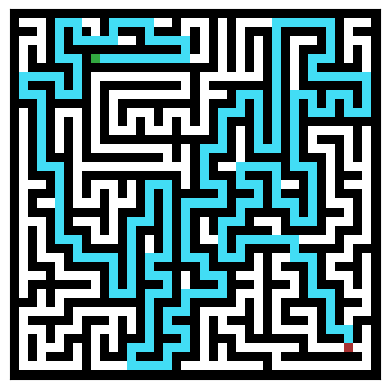

CPU times: user 399 ms, sys: 50.3 ms, total: 449 ms
Wall time: 463 ms


In [11]:
%%time
pf = pathfinder(S, F, map, lambda x, y: 1, euclidean)
map.draw_map(pf.get_path())

In [12]:
expanded_nodes = pf.get_complexity()
print('Number of expanded nodes:', expanded_nodes)

Number of expanded nodes: 605


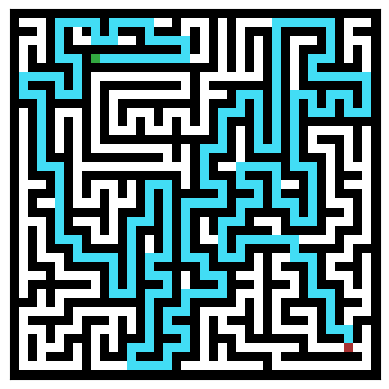

CPU times: user 240 ms, sys: 20 ms, total: 260 ms
Wall time: 232 ms


In [19]:
%%time
pf = pathfinder(S, F, map, lambda x, y: 0, manhattan)
map.draw_map(pf.get_path())

In [14]:
expanded_nodes = pf.get_complexity()
print('Number of expanded nodes:', expanded_nodes)

Number of expanded nodes: 422




---



## Μέρος 3


---


Στο τρίτο μέρος καλείστε να υλοποιήσετε μια συγκριτική μελέτη των αλγορίθμων που κατασκευάσατε στο Μέρος 2 με σκοπό να καταλήξετε σε ορισμένα συμπεράσματα. Οι αλγόριθμοι θα συγκρίνονται με βάση την πολυπλοκότητά τους και το κατά πόσο μπορούν να βρούν το βέλτιστο μονοπάτι.

Για να κρίνουμε τον τρόπο με τον οποίο το μέγεθος του λαβύρινθου επηρεάζει τους αλγορίθμους, κατασκευάζουμε χάρτες με διάσταση $N=[10,20,\ldots,100]$. Για κάθε παραμετροποίηση προτείνεται να κατασκευάζετε 100 διαφορετικούς χάρτες, στους οποίους θα εκτελείτε τους παραπάνω αλγορίθμους.

Έπειτα, ζητείται να συλλέξετε τα εξής χαρακτηριστικά:
 * το μήκος του ελάχιστου μονοπατιού που εξάγει ο εκάστοτε αλγόριθμος.
 * το πλήθος των επεκτεταμένων κόμβων (expanded nodes) του κάθε αλγορίθμου, που αποτελεί μέτρο της πολυπλοκότητάς του.

 Για να σας είναι εύκολο να εξάγετε συμπεράσματα από τις παραπάνω παραμετροποιήσεις, ζητείται να κατασκευάσετε δύο γραφικές παραστάσεις:
 * το μήκος του ελάχιστου μονοπατιού συναρτήσει του μεγέθους του χάρτη
 * το πλήθος των expanded nodes συναρτήσει του μεγέθους του χάρτη



 Σας ζητείται σχολιάσετε τις παραπάνω γραφικές παραστάσεις, και συγκεκριμένα το πώς μεταβάλλεται η συμπεριφορά των αλγορίθμων συναρτήσει του $N$.

 Σημειώνουμε τα παρακάτω:

 * Σε όλα τα παραπάνω πειράματα μπορείτε να λάβετε σαν σημείο εκκίνησης το $(1,1)$ και σαν σημείο τερματισμού το $(N-2,N-2)$. Εναλλακτικά, μπορείτε να πειραματισθείτε με τυχαία σημεία εκκινησης και τερματισμού.
 * Αν και οι χάρτες παράγονται τυχαία, η εκτέλεση αλγορίθμων σε διαφορετικούς χάρτες παράγει μη συγκρίσιμα αποτελέσματα.
 * Για λόγους ευκολίας σύγκρισης, προτείνεται να τοποθετήσετε πολλαπλές γραφικές παραστάσεις στο ίδιο σύστημα αξόνων, όπου αυτό είναι εφικτό.

**Visualization**: Παράλληλα με τα παραπάνω σάς δίνεται έτοιμη και μια κλάση η όποια κατασκευάζει ένα animation της αναζήτησης το οποίο υλοποιεί κάθε αλγόριθμος. Για την χρήση της κλάσης αυτής πρέπει να κάνετε τα εξής 4 βήματα:

1.	Δημιουργία ενός instance της κλάσης εκτελώντας την παρακάτω εντολή: `visualization(Start, Goal)`. Η εντολή αυτή δημιουργεί ένα αντικείμενο τύπου visualization.
2.	Το βίντεο που παράγεται κάθε φορά ουσιαστικά αποτελείται από stacked frames. Συνεπώς σε κάθε βήμα εκτέλεσης όπου δηλαδή θέλουμε να προσθέσουμε ένα frame στο βίντεο πρέπει να καλέσουμε την μέθοδο της κλάσης: `draw_step(grid, frontier, expanded_nodes)` όπου το πρώτο όρισμα είναι ένας χάρτης (τύπου Maze) το δεύτερο μια λίστα με το μέτωπο της αναζήτηση ενώ το τρίτο μια λίστα με τους κόμβους οι όποιοι έχουν ήδη επεκταθεί από τον αλγόριθμο.
3.	(Προαιρετικό) Αν θέλουμε να προσθέσουμε στο animation και το βέλτιστο μονοπάτι που βρήκε ο αλγόριθμός μας μπορούμε να καλέσουμε την μέθοδο add_path(path) η οποία δέχεται σαν όρισμα μια λίστα με όλους τους κόμβους που ανήκουν στο βέλτιστο μονοπάτι (συμπεριλαμβανομένων και των κόμβων αρχής και τέλους).
4.	Τέλος καλούμε την συνάρτηση `show_gif()` η όποια εμφανίζει το animation. Επίσης μπορούμε και να αποθηκεύσουμε το gif καλώντας την συνάρτηση `save_gif (filename)` (το αρχείο πρέπει να έχει κατάληξη .gif) καθώς επίσης μπορούμε να εμφανίσουμε μόνο το τελευταίο frame καλώντας την συνάρτηση `show_last_frame()` στο όποιο (αν έχουν γίνει όλα όπως παραπάνω) θα φαίνονται όλοι οι κόμβοι οι οποίοι έχουν επεκταθεί από τον αλγόριθμο, το τελευταίο μέτωπο και (προαιρετικά) και το βέλτιστο μονοπάτι.

Μπορείτε να καταλήξετε στα ίδια συμπεράσματα όσον αφορά την πολυπλοκότητα των αλγορίθμων παρατηρώντας το visualization;


Στο παρακάτω κελί σάς δίνεται ένα παράδειγμα για την κατασκευή γραφικών παραστάσεων. Θα πρέπει να κατασκευάσετε τις δύο γραφικές παραστάσεις σύμφωνα με τα ζητούμενα της άσκησης.

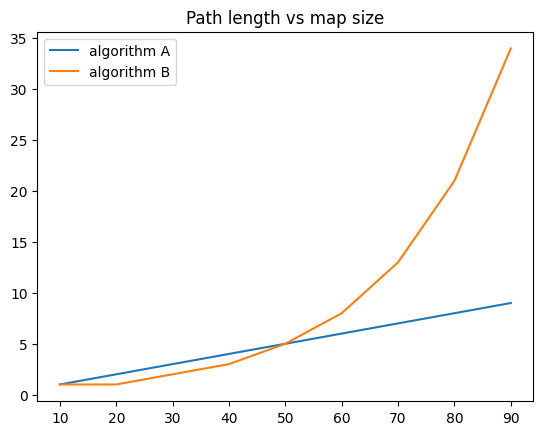

In [ ]:
path_lengths_a = [1,2,3,4,5,6,7,8,9]
path_lengths_b = [1,1,2,3,5,8,13,21,34]
map_sizes = [10,20,30,40,50,60,70,80,90]

plt.plot(map_sizes, path_lengths_a)
plt.plot(map_sizes, path_lengths_b )
plt.legend(['algorithm A', 'algorithm B'])
plt.title('Path length vs map size')
plt.show()

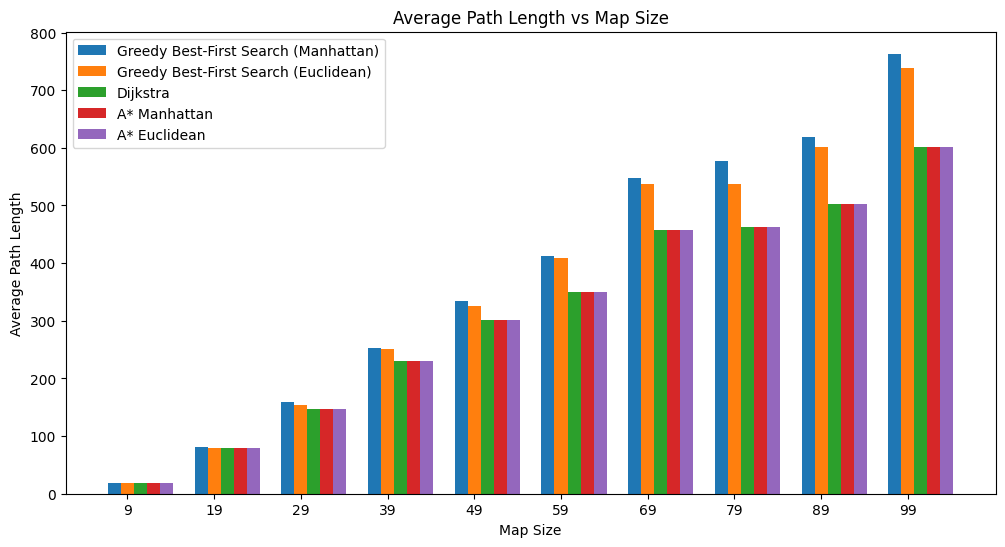

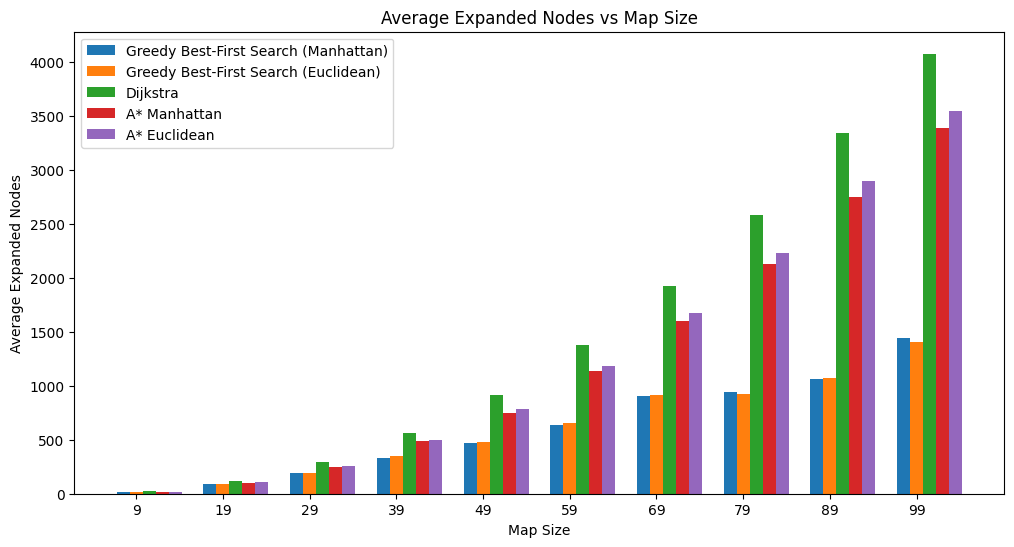

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming the Pathfinder and other classes/functions are already imported

# Prepare data storage
map_sizes = list(range(9, 100, 10))  # Use odd sizes for compatibility with your maze generation
algorithm_results = {
    'Greedy Best-First Search (Manhattan)': {'path_lengths': [], 'expanded_nodes': []},
    'Greedy Best-First Search (Euclidean)': {'path_lengths': [], 'expanded_nodes': []},
    'Dijkstra': {'path_lengths': [], 'expanded_nodes': []},
    'A* Manhattan': {'path_lengths': [], 'expanded_nodes': []},
    'A* Euclidean': {'path_lengths': [], 'expanded_nodes': []}
}

# Simulation
for N in map_sizes:
    for _ in range(100):  # Generate 100 mazes per size
        S, F = (1, 1), (N-2, N-2)  # Ensure start and finish are valid
        maze = Maze(N, S, F)

        # Instantiate pathfinders with different configurations
        configurations = [
            ('Greedy Best-First Search (Manhattan)', (lambda x, y: 0, manhattan)),
            ('Greedy Best-First Search (Euclidean)', (lambda x, y: 0, euclidean)),
            ('Dijkstra', (lambda x, y: 1, lambda x, y: 0)),
            ('A* Manhattan', (lambda x, y: 1, manhattan)),
            ('A* Euclidean', (lambda x, y: 1, euclidean))
        ]

        for config_name, (g, h) in configurations:
            pf = pathfinder(S, F, maze, g, h)
            path = pf.get_path()
            path_length = len(path)
            expanded_nodes = pf.get_complexity()

            algorithm_results[config_name]['path_lengths'].append(path_length)
            algorithm_results[config_name]['expanded_nodes'].append(expanded_nodes)

# Plotting results for Path Length
bar_width = 0.15  # width of bars in the bar chart
index = np.arange(len(map_sizes))  # index for bar positions

plt.figure(figsize=(12, 6))
for i, (algorithm, data) in enumerate(algorithm_results.items()):
    avg_path_lengths = [np.mean(data['path_lengths'][j*100:(j+1)*100]) for j in range(len(map_sizes))]
    plt.bar(index + i * bar_width, avg_path_lengths, width=bar_width, label=f'{algorithm}')

plt.xticks(index + bar_width, map_sizes)  # Set x-axis ticks to be at the center of the grouped bars
plt.legend()
plt.title('Average Path Length vs Map Size')
plt.xlabel('Map Size')
plt.ylabel('Average Path Length')
plt.show()

# Plotting results for Expanded Nodes
plt.figure(figsize=(12, 6))
for i, (algorithm, data) in enumerate(algorithm_results.items()):
    avg_expanded_nodes = [np.mean(data['expanded_nodes'][j*100:(j+1)*100]) for j in range(len(map_sizes))]
    plt.bar(index + i * bar_width, avg_expanded_nodes, width=bar_width, label=f'{algorithm}')

plt.xticks(index + bar_width, map_sizes)
plt.legend()
plt.title('Average Expanded Nodes vs Map Size')
plt.xlabel('Map Size')
plt.ylabel('Average Expanded Nodes')
plt.show()




---



## Μέρος 4


---


Στο τέταρτο μέρος της εργασίας στο λαβύρινθο υπάρχει ένα φάντασμα 👻! Ο στόχος είναι να φτάσουμε στο σημείο τερματισμού αποφεύγοντας το φάντασμα, το οποίο μας κυνηγάει τρέχοντας σε κάθε βήμα τον δικό του Α*. Ο κώδικας που τρέχει το φάντασμα ''Agent'' σας δίνεται έτοιμος.

Για την αποφυγή του φαντάσματος θα υλοποιήσουμε τον αλγόριθμο ΑΒ. Συγκεκριμένα, σας δίνεται η κλάση ''ΑΒagent'' στην οποία καλείστε να συμπληρώσετε τις κινήσεις του minimizing_player (όπως διδαχθήκατε στο μάθημα), δεδομένων των αντίστοιχων κινήσεων του maximizing_player. Στα πλαίσια του αλγορίθμου αυτού θα χρειαστεί να ορίσετε μια ευριστική συνάρτηση η οποία εκτιμά το κόστος της επόμενης κατάστασης συνυπολογίζοντας την απόσταση τόσο από το στόχο και από το φάντασμα.

Περιγράψτε στο κατάλληλο markdown κελί τη συλλογιστική πορεία για τις επιλογές σας όσον αφορά την ευριστική. Πώς υπολογίσατε τις αποστάσεις (με εκτίμηση/πραγματική μετρική); Αναφέρετε αναλυτικά τα αποτέλεσματα και τις παρατηρήσεις σας σχετικά με τις παραπάνω επιλογές. Μεγαλύτερη σημασία έχει ο πειραματισμός και η αναφορά των αποτελεσμάτων, όσον αφορά αφορά την ευριστική, παρά η αναζήτηση της καλύτερης συνάρτησης. Ως αποτελέσματα ζητείται να παραθέσετε: χαρακτηριστικά gifs και χρόνους εκτέλεσης. Δικαιολογείστε γιατί ο αλγόριθμός σας δουλεύει ορθά.

**ΠΡΟΣΟΧΗ!** Στο 4ο μέρος οι λαβύρινθοι που θα χρησιμοποιήσετε πρέπει να είναι αραιοί ως προς τα εμπόδια. Αν τα υπάρχοντα μονοπάτια προς το στόχο είναι λίγα, θα είναι δύσκολο να ξεφύγετε από το φάντασμα ανεξαρτήτως υλοποίησης.

In [ ]:
class Agent:
  def __init__(self,S,grid,color, name = ""):
    self.agent_name = name
    self.location = S
    self.color=color
    self.maze = grid
    self.maze.agents.append(self)
    self.maze.grid[S]=1
    self.path=[]

  def find_path(self,F):
    c = lambda x,y: 1
    h = euclidean
    pf = pathfinder(self.location, F, self.maze, c, h, visualize=False)
    self.path = pf.path


  def move(self):
    if len(self.path)<1:
      return
    if self.location==self.path[0] and len(self.path)>1:
      self.location=self.path[1]
      self.path = self.path[2:]
    else:
      self.location=self.path[0]
      self.path=self.path[1:]

  def move_to(self, loc):
    self.location = loc

Στη συνέχεια, δίνεται ο κώδικας για τον agent που τρέχει να ξεφύγει. Ο ABagent τρέχει ΑΒ με σκοπό να φτάσει στον τερματισμό χωρίς να τον πιάσει το φάντασμα. Καλείστε να συμπληρώσετε τα σημεία που παραλείπονται. Δώστε ιδιαίτερη προσοχή στην ευριστική συνάρτηση. Εξηγείστε τις επιλογές σας, όπως περιγράφεται παραπάνω.

In [ ]:
class ABagent:
  def __init__(self, S, grid, color, name = ""):
    self.agent_name = name
    self.location = S
    self.color=color
    self.maze = grid
    self.maze.agents.append(self)
    self.maze.grid[S]=1
    self.path=[]

  def get_best_action(self, ghosts, depth = 3):
      best_action = None
      best_score = float("-inf") #you can use this for debugging
      alpha = float("-inf")
      beta = float("inf")

      best_score, best_action = self.alpha_beta_agent(self.maze, self.location, ghosts, depth, alpha, beta, True)

      return best_action

  def alpha_beta_agent(self, maze, agent_pos, ghost_positions, depth, alpha, beta, maximizing_player=True):
      if depth == 0 or self.is_win(maze, agent_pos) or self.is_lose(agent_pos, ghost_positions):
          # Return the heuristic value if we've reached the maximum depth or the game is over
          return self.heuristic_AB(map, agent_pos, ghost_positions), agent_pos

      if maximizing_player:
          # Agent is the maximizing player
          best_score = float("-inf")
          best_action = None
          for successor_state in maze.adjacent_no_walls(agent_pos):
              score, _ = self.alpha_beta_agent(maze, successor_state, ghost_positions, depth - 1, alpha, beta, False)
              if score > best_score:
                  best_score = score
                  best_action = successor_state
              alpha = max(alpha, score)
              if beta <= alpha:
                  break
          return best_score, best_action
      else:
          # Ghosts are the minimizing players
          ### ### ### ### ### ###
          ### YOUR CODE HERE \/

          worst_score = float("inf")
          worst_action = None
          for successor_state in maze.adjacent_no_walls(ghost_positions[0]):
            score, _ = self.alpha_beta_agent(maze, agent_pos, [successor_state], depth - 1, alpha, beta, True)
            if score < worst_score:
              worst_score = score
              worst_action = successor_state
            beta = min(beta, score)
            if beta <= alpha:
              break
          return worst_score, worst_action

          ### YOUR CODE HERE /\
          ### ### ### ### ### ###

  def is_win(self, maze, agent):

      ### ### ### ### ### ###
      ### YOUR CODE HERE \/

      return agent == maze.F

      ### YOUR CODE HERE /\
      ### ### ### ### ### ###

  def is_lose(self, agent, ghosts):

      ### ### ### ### ### ###
      ### YOUR CODE HERE \/

      return agent in ghosts

      ### YOUR CODE HERE /\
      ### ### ### ### ### ###

  def heuristic_AB(self, map, agent_pos, ghost_positions):

      ### ### ### ### ### ###
      ### YOUR CODE HERE \/

      goal = map.F  # Assuming goal position is stored in the map
      agent_to_goal = manhattan(agent_pos, goal)
      agent_to_ghost = manhattan(agent_pos, ghost_positions[0])  # assuming one ghost for simplicity

      # Simple heuristic: Minimize distance to goal, maximize distance from ghost
      return (300 - agent_to_goal) + agent_to_ghost * 2  # weight distance from ghost more

      ### YOUR CODE HERE /\
      ### ### ### ### ### ###

  def move_to(self, loc):
    self.location = loc

Φτιάχνουμε αραιό χάρτη και ορίζουμε τους agents.

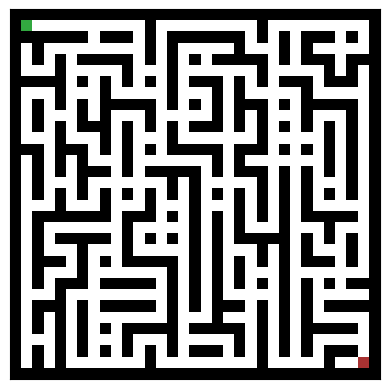

In [ ]:
#create a sparse map with many paths, like the one below
map = Maze(33, (1,1), (31,31), threshold=0.1)
map.draw_map()

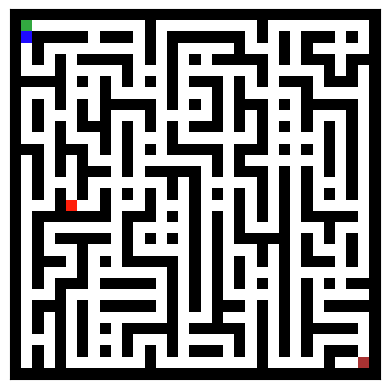

In [ ]:
x, y = np.random.choice(range(1, 31)), np.random.choice(range(1, 31))
ghost = (Agent((x, y), map, [255,30,10], "ghost"))

a1 = ABagent((2,1), map,[30,10,255], "agentAB")

map.draw_map()

Παρακάτω, υλοποιείται το κυνηγητό. Ενδεικτικά ορίζουμε την παράμετρο depth του ΑΒ ίση με 5.

Προσοχή: όπως σημειώνεται, μπορούμε να κάνουμε τους παίκτες να τρέχουν με διαφορετικές ταχύτητες. Είναι προτιμητέο να κρατήσετε την ταχύτητα ίση (όπως παρακάτω). Διαφορετικά, θα χρειαστεί να τροποποιήσετε τον αλγόριθμο ΑΒ.

Μετρείστε το χρόνο εκτέλεσης και παρουσιάστε παραδείγματα. Γιατί ο αλγόριθμος σας δουλεύει;

In [ ]:
vis=visualization((1,1),(31,30))

visited = [a1.location] #HINT: this might be helpful to you

for i in range(100):
  if a1.location==(31,31):
    print("Win")
    break

  if a1.location == ghost.location:
    print("Lose")
    break

  if i%1==0: #controls agent speed
    best_move = a1.get_best_action([ghost.location], 5)
    a1.move_to(best_move)
    visited.append(a1.location)

  if i%1==0: #controls ghost speed
    ghost.find_path(a1.location)
    ghost.move()

  im = map.draw_map(return_image=True)
  vis.images.append(im)

Win


In [ ]:
vis.create_gif(fps=1)
vis.show_gif()



---


## Ευρετικός σχεδιασμός για ABagent σε λαβύρινθο φαντασμάτων

### Πλαίσιο και στόχος
Σε αυτό το σενάριο λαβύρινθου, ο `ΑΒagent` μας πρέπει να πλοηγηθεί προς ένα στόχο αποφεύγοντας ένα φάντασμα που τον καταδιώκει. Το φάντασμα χρησιμοποιεί έναν αλγόριθμο A* για να προβλέψει και να ανακόψει την πορεία του πράκτορα, γεγονός που καθιστά αναγκαία μια ισχυρή στρατηγική για ασφαλή πλοήγηση.

### Ευρετική στρατηγική
Η ευρετική μας στρατηγική συνδυάζει δύο κρίσιμα στοιχεία χρησιμοποιώντας τη μετρική της απόστασης Μανχάταν λόγω της βασισμένης σε πλέγμα φύσης του λαβύρινθου και της απουσίας διαγώνιων κινήσεων:
- **Απόσταση από το στόχο**: Ενθαρρύνει τον πράκτορα προς τον στόχο, ελαχιστοποιώντας έτσι αυτή την απόσταση.
- **Απόσταση από το φάντασμα**: Δίνει προτεραιότητα στην ασφάλεια του πράκτορα, μεγιστοποιώντας αυτή την απόσταση διαχωρισμού.

Για την εξισορρόπηση αυτών των παραγόντων, η ευρετική διαμορφώνεται ως `H = 300 - agent_to_goal + 2 * agent_to_ghost`, θέτοντας υψηλότερη ποινή στην εγγύτητα με το φάντασμα από ό,τι στην απόσταση από τον στόχο.

### Εφαρμογή και αποτελέσματα
Εφαρμοσμένη σε έναν αλγόριθμο κλαδέματος άλφα-β, η ευρετική καθοδηγεί τις αποφάσεις μεγιστοποίησης του πράκτορα έναντι των αντιδράσεων ελαχιστοποίησης του φαντάσματος.

**Πειραματικές παρατηρήσεις**:
- **Ανάλυση του GIF**: Οι επιδείξεις δείχνουν ότι ο πράκτορας αλλάζει την πορεία του όταν πλησιάζει το φάντασμα, επικυρώνοντας την αποτελεσματικότητα της ευρετικής μας στη λήψη αποφάσεων σε πραγματικό χρόνο.
- **Αποτελεσματικότητα χρόνου εκτέλεσης**: Ο μέσος χρόνος λήψης αποφάσεων παραμένει εντός αποδεκτών ορίων, εξασφαλίζοντας την ανταπόκριση του πράκτορα ακόμη και υπό την πιθανή εγγύτητα του φαντάσματος.

### Συμπέρασμα
Η ευρετική καθοδηγεί αποτελεσματικά τον πράκτορα να εξισορροπεί την πρόοδο του στόχου με ελιγμούς αποφυγής. Αυτή η διπλή εστίαση εξασφαλίζει ότι ο πράκτορας παραμένει προσανατολισμένος στο στόχο αλλά προσεκτικός, επιβεβαιώνοντας τη λογική σχεδιασμού της ευρετικής και την επιτυχή εφαρμογή της στο περιβάλλον του λαβύρινθου.

---



# Μέρος 5 (bonus)


---


Στο πέμπτο και τελευταίο μέρος της εργασίας σάς δίνεται η δυνατότητα να κατασκευάσετε λαβυρίνθους με το χέρι, ζωγραφίζοντας. Για το σκοπό αυτό σας δίνεται η συνάρτηση draw(filename='filename.png') η οποία παράγει ένα interactive grid ώστε να σχηματίσετε το λαβύρινθο. Θεωρήστε ως μαύρο το χρώμα του εμποδίου, πράσινο την αφετηρία και κόκκινο το στόχο, και πατήστε finish για να ολοκληρωθεί η εκτέλεση του τρέχοντος κελιού. Σε περίπτωση που θέλετε να παράξετε νέο λαβύρινθο, απλά ξανατρέξτε το κελί, επιλέξτε τα τετράγωνα και πατήστε finish. Κάθε εκτέλεση αποθηκεύει την εικόνα σε μορφή png σε όνομα που μπορείτε να καθορίσετε μέσω του filename (τοποθετώντας και την κατάληξη .png) κατά την κλήση της συνάρτησης.  

Καλείστε λοιπόν να **κατασκευάσετε** και να **σχολιάσετε** τους παρακάτω 5 λαβυρίνθους, οι οποίοι θα ικανοποιούν τις παρακάτω συνθήκες:


*   **Λαβύρινθος 1**: Ο Hill-climbing δεν βρίσκει μονοπάτι από την αφετηρία στο στόχο.
*   **Λαβύρινθος 2**: Ο Α* αργεί όσο το δυνατόν περισσότερο να βρει το βέλτιστο μονοπάτι ανεξαρτήτως της μετρικής απόστασης που χρησιμοποιείται ως ευριστική. Σε τι είδους μονοπάτι η επιλογή διαφορετικής μετρικής απόστασης (Ευκλίδεια/Manhattan) ως ευριστικής οδηγεί τον Α* να βρίσκει το μονοπάτι πιο γρήγορα;
*   **Λαβύρινθος 3**: Ο αλγόριθμος άπληστης αναζήτησης πρώτα στο καλύτερο (greedy best first) αργεί σημαντικά περισσότερο από τον Α* για να καταλήξει στο στόχο. Σε ποια περίπτωση οι δύο αλγόριθμοι θα συμπεριφέρονταν με τον ίδιο τρόπο;
*   **Λαβύρινθος 4**: Ο Α* καταφέρνει να βρει το μονοπάτι προς το στόχο σημαντικά πιο γρήγορα από τον Dijkstra. Ο χώρος πρέπει αναγκαστικά να περιέχει εμπόδια. Πώς επηρεάζει το μέγεθος/είδος του εμποδίου τον αριθμό βημάτων που χρειάζεται ο Dijsktra και πώς τον αριθμό βημάτων του Α*;
*   **Λαβύρινθος 5**: Ο Α* και ο Dijkstra φτάνουν στο στόχο πραγματοποιώντας τον ίδιο ακριβώς αριθμό βημάτων για την προσέγγιση της βέλτιστης διαδρομής. Σημείωση: **αγνοήστε** την τετριμμένη περίπτωση όπου ο Α* συμπεριφέρεται όπως ο Dijkstra (h(n)=0).


Ο Α* σε όλες τις περιπτώσεις πραγματοποιεί τη βέλτιστη δυνατή αναζήτηση.   


Για κάθε λαβύρινθο που σχηματίζετε, δώστε μια σύντομη εξήγηση για την επιλογή σας.  

**ΠΡΟΣΟΧΗ:** το output των κελιών που σχηματίζετε διατηρείται για περιορισμένο χρονικό διάστημα στο notebook, γι αυτό καλείστε να αποθηκεύσετε τη φωτογραφία (το πραγματοποιεί η συνάρτηση draw()) και να τη μεταφέρετε στο ανάλογο markdown ώστε να μπορέσουμε να την αξιολογήσουμε.


Στη συνέχεια, καλείστε να τρέξετε τους αλγορίθμους pathfinding πάνω στους χάρτες που σχηματίσατε. Για το σκοπό αυτό, μετά την εκτέλεση της draw() καλείτε τη συνάρτηση draw_grid() που μετατρέπει την εικόνα που σχηματίσατε σε χάρτη πάνω στον οποίο μπορούν να τρέξουν οι αλγόριθμοι με χρήση της συνάρτησης pathfinder(). Χρειάζεται να επιλέξετε κατάλληλα τα ορίσματα της pathfinder ώστε να καλέσετε το σωστό αλγόριθμο αναζήτησης σε κάθε ερώτημα. Εκτελέστε τα αντίστοιχα κελιά με τον κώδικα που σας δίνεται και παρουσιάστε την έξοδο αυτών. Φυσικά, εάν ένα ερώτημα περιλαμβάνει την εκτέλεση περισσότερων του ενός αλγορίθμου, αντιγράφετε τα αντίστοιχα κελιά για κάθε αλγόριθμο και τοποθετείτε τα σωστά ορίσματα. Τέλος, η show_gif() σάς παρουσιάζει το animation, όπως και στο Μέρος 3.
**Παρατήρηση:** εφόσον δε σας δίνεται/δεν έχετε υλοποιήσει τον Hill climbing, δε σας ζητείται να τον τρέξετε στο χάρτη που θα σχηματίσετε.

Υπενθυμίζεται ότι το output των κελιών που σχηματίζετε διατηρείται για περιορισμένο χρονικό διάστημα στο notebook, γι αυτό καλείστε να αποθηκεύσετε τη φωτογραφία (το πραγματοποιεί η συνάρτηση draw()) και να τη μεταφέρετε στο ανάλογο markdown.

In [ ]:
from IPython.display import HTML, Image
from google.colab.output import eval_js
from base64 import b64decode
import PIL


canvas_html = """
<canvas width=301 height=301></canvas>
<br>

<button id = "start" style="background-color: #008000">Start</button>
<button id = "end" style="background-color: #800000">End</button>
<button id = "finish">Finish</button>
<script>

var canvas = document.querySelector('canvas')
var ctx = canvas.getContext('2d')

for (var x = 0.5; x < 301; x += 20) {
  ctx.moveTo(x, 0);
  ctx.lineTo(x, 300);
}

for (var y = 0.5; y < 301; y += 20) {
  ctx.moveTo(0, y);
  ctx.lineTo(300, y);
}

ctx.strokeStyle = "#000";
ctx.stroke();

var button = document.getElementById('finish')
var start_button = document.getElementById('start')
var end_button = document.getElementById('end')


start_button.onclick = ()=>{
    ctx.fillStyle="#008000";
  }

end_button.onclick = ()=>{
    ctx.fillStyle="#800000";
  }


var mouse = {x: 0, y: 0}
canvas.addEventListener('mousemove', function(e) {
  mouse.x = e.pageX - this.offsetLeft
  mouse.y = e.pageY - this.offsetTop
})

function getMousePos(canvas, evt) {
        var rect = canvas.getBoundingClientRect();
        return {
          x: evt.x - rect.left,
          y: evt.y - rect.top
        };
      }

function getNearestSquare(position) {
    var x = position.x;
    var y = position.y;

    if (x < 0 || y < 0) return null;
    x = (Math.floor(x / 20) * 20) + 0.5
    y = (Math.floor(y / 20) * 20) + 0.5
    return {x: x, y: y};
}

function containsObject(obj, list) {
    var i;
    for (i = 0; i < list.length; i++) {
        if (list[i].x === obj.x && list[i].y == obj.y) {
            return i;
        }
    }
    return -1;
}

borders = []

canvas.onmousedown = ()=>{
    var pos = getNearestSquare(getMousePos(canvas, mouse));
    if (pos != null) {
        index = containsObject(pos, borders)
        if (index != -1){
            borders.splice(index, 1)
            ctx.clearRect(pos.x + 1, pos.y, 19, 19)
        }
        else{
            ctx.fillRect(pos.x+1,pos.y+1,18,18);
            borders.push(pos)
        }
        ctx.fillStyle="#000000";
    }
}
var data = new Promise(resolve=>{
  button.onclick = ()=>{
    resolve(canvas.toDataURL('image/png'))
  }
})
</script>
"""

def draw(filename='drawing.png'):
  display(HTML(canvas_html))
  data = eval_js("data")
  print (data)
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return len(binary)


draw()

In [ ]:
def find_points(image_array, pixels):
    points = []
    for grid_i, i in enumerate(range (10, image_array.shape[0]-10, 20)):
        for grid_j, j in enumerate(range (10, image_array.shape[1]-10, 20)):
            if np.array_equal(image_array[i][j], pixels):
                points.append([grid_i+1, grid_j+1])
    return points

def draw_grid(fname='/content/drawing.png'):
    N = 17
    image = PIL.Image.open(fname)
    image_array = np.round(np.array(image)/255)

    start_x, start_y = find_points(image_array, [0,1,0,1])[0]
    end_x, end_y = find_points(image_array, [1, 0, 0, 1])[0]
    walls = find_points(image_array, [0, 0, 0, 1])
    new_grid = Maze(N, (start_x, start_y), (end_x, end_y))

    for i in range(N):
        for j in range(N):
            if [i, j] in walls:
                new_grid.grid[i,j] = 0
            else:
                new_grid.grid[i, j] = 1

    g = new_grid
    g.draw_map()
    return g

g = draw_grid()

In [ ]:
pf = pathfinder(g.S, g.F, g, lambda x, y: 1, lambda x, y: 0)
g.draw_map(pf.get_path())

In [ ]:
pf.vis.show_gif()



---


# **Ερώτημα 5.1:** Ο Hill-climbing δεν βρίσκει μονοπάτι από την αφετηρία στο στόχο.

In [ ]:
draw(filename='5.2.png') # We use this to generate the different mazes.

In [ ]:
from google.colab import drive
from IPython.display import Image, display
drive.mount('/content/drive/')

1. Εισάγετε εδώ την φωτογραφία όπως αυτή προέκυψε από την εκτέλεση και αλληλεπίδραση με το παραπάνω κελί, όπως επίσης και τον σχολιασμό σας.  

(Υπενθύμιση: για τον Hill Climbing δε χρειάζετει να τρέξετε το χάρτη που σχηματίσατε)

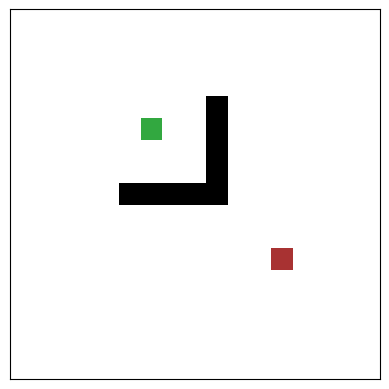

In [90]:
g1 = draw_grid('/content/drive/MyDrive/Ece-Ntua/Lab_AI/Exercise_1/5.1.png')

Επειδή ο Hill Climbing επιλέγει τις καταστάσεις - κελλιά με την χαμηλότερη τιμή ευρετικής και δεν διατηρεί τις υπόλοιπες στο μέτωπο αναζήτησης, κατευθυνόμενος προς αυτές με την χαμηλότερη απόσταση (Ευκλείδια ή Manhattan) θα φθάσει στο αδιέξοδο και θα τερματίσει χωρίς να βρει λύση.



---


# **Ερώτημα 5.2:**  Ο Α* αργεί όσο το δυνατόν περισσότερο να βρει το βέλτιστο μονοπάτι ανεξαρτήτως της μετρικής απόστασης που χρησιμοποιείται ως ευριστική.  

1. Εισάγετε εδώ την φωτογραφία όπως αυτή προέκυψε από την εκτέλεση και αλληλεπίδραση με το παραπάνω κελί, όπως επίσης και τον σχολιασμό σας.
2. Σε τι είδους μονοπάτι η επιλογή διαφορετικής μετρικής απόστασης (Ευκλίδεια/Manhattan) ως ευριστικής οδηγεί τον Α* να βρίσκει το μονοπάτι πιο γρήγορα;

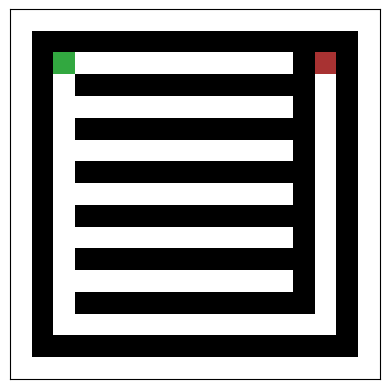

In [91]:
g2 = draw_grid('/content/drive/MyDrive/Ece-Ntua/Lab_AI/Exercise_1/5.2.png')

In [96]:
pf2 = pathfinder(g2.S, g2.F, g2, c = lambda x, y: 1, h = lambda x, y: euclidean) # A* algorithm
g2.draw_map(pf2.get_path())

TypeError: unsupported operand type(s) for +: 'int' and 'function'

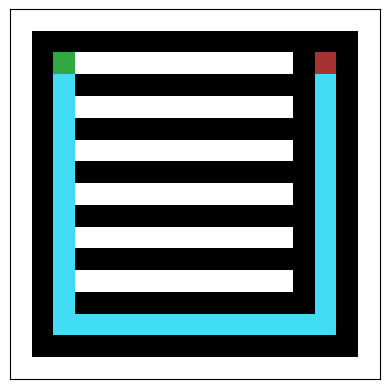

In [92]:
pf2 = pathfinder(g2.S, g2.F, g2, c = lambda x, y: 1, h = lambda x, y: 0) # Dijkstra
g2.draw_map(pf2.get_path())

Σε αυτόν τον λαβύρινθο ο Α* αναγκάζεται να αναζητήσει όλα τα κελλιά πριν βρει την μοναδική σωστή διαδρομή, γιατί αυτή έχει τις μεγαλύτερες δυνατές τιμές f(n).



---


# **Ερώτημα 5.3:** Ο Greedy Best First αργεί σημαντικά περισσότερο από τον Α* για να καταλήξει στο στόχο.

1. Εισάγετε εδώ την φωτογραφία όπως αυτή προέκυψε από την εκτέλεση και αλληλεπίδραση με το παραπάνω κελί, όπως επίσης και τον σχολιασμό σας.
2. Σε ποια περίπτωση οι δύο αλγόριθμοι θα συμπεριφέρονταν με τον ίδιο τρόπο;


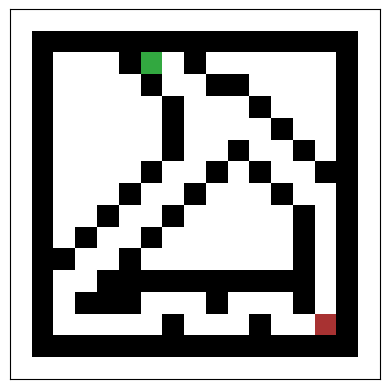

In [95]:
g3 = draw_grid('/content/drive/MyDrive/Ece-Ntua/Lab_AI/Exercise_1/5.3.png')

Στον παραπάνω λαβύρινθο φαίνεται ένα παράδειγμα όπου ο Best First δεν βρίσκει την βέλτιστη λύση, επειδή καθοδηγείται από ανεπαρκή ευρετική, ενώ ο A*  , επειδή λαμβάνει υπ' όψιν και την συνάρτηση κόστους, επιλέγει την σωστή κατεύθυνση. Εναλλακτικά, σε έναν λαβύρινθο όπου το βέλτιστο μονοπάτι απαιτεί προσωρινή μετακίνηση προς υψηλότερη ευρετική, ο Best-First δεν θα το επέλεγε και θα χάραζε διαδρομή μεγαλύτερου μήκους, ενώ ο Α* θα το εντόπιζε.

In [98]:
pf3 = pathfinder(g3.S, g3.F, g3, c = lambda x, y: 1, h = lambda x, y: euclidean)   # A* algrorithm
g3.draw_map(pf3.get_path())

TypeError: unsupported operand type(s) for +: 'int' and 'function'

In [99]:
pf3 = pathfinder(g3.S, g3.F, g3, c = lambda x, y: 0, h = lambda x, y: euclidean)   # Greedy
g3.draw_map(pf3.get_path())

TypeError: unsupported operand type(s) for +: 'int' and 'function'

In [ ]:
pf.vis.show_gif()



---



# **Ερώτημα 5.4:** Ο Α* καταφέρνει να βρει το μονοπάτι προς το στόχο σημαντικά πιο γρήγορα από τον Dijkstra.

1. Εισάγετε εδώ την φωτογραφία όπως αυτή προέκυψε από την εκτέλεση και αλληλεπίδραση με το παραπάνω κελί, όπως επίσης και τον σχολιασμό σας.
2. Ο χώρος πρέπει αναγκαστικά να περιέχει εμπόδια.
3. Πώς επηρεάζει το μέγεθος/είδος του εμποδίου τον αριθμό βημάτων που χρειάζεται ο Dijsktra και πώς τον αριθμό βημάτων του Α*;


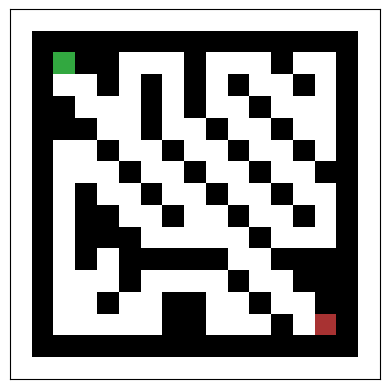

In [87]:
g4 = draw_grid('/content/drive/MyDrive/Ece-Ntua/Lab_AI/Exercise_1/5.4.png')

Περιμένουμε σημαντική διαφορά στον χρόνο εύρεσης λύσης, η οποία οφείλεται στο γεγονός πως η χρήση της ευρετικής καθοδηγεί τον Α* πρώτα προς την σωστή κατεύθυνση, ενώ ο Dijkstra εξερευνά όλες τις διακλαδώσεις.

In [89]:
pf4= pathfinder(g4.S, g4.F, g4, c = 1, h = lambda x, y: manhattan)
g4.draw_map(pf4.get_path())

TypeError: 'int' object is not callable

In [107]:
pf4 = pathfinder(g4.S, g4.F, g4, c = lambda x, y: 1, h = lambda x, y: 0)   # Dijkstra
pf4.vis.show_gif()



---



# **Ερώτημα 5.5:** Ο Α* και ο Dijkstra φτάνουν στο στόχο πραγματοποιώντας τον ίδιο ακριβώς αριθμό βημάτων για την προσέγγιση της βέλτιστης διαδρομής.

1. Εισάγετε εδώ την φωτογραφία όπως αυτή προέκυψε από την εκτέλεση και αλληλεπίδραση με το παραπάνω κελί, όπως επίσης και τον σχολιασμό σας.
2. Σημείωση: **αγνοήστε** την τετριμμένη περίπτωση όπου ο Α* συμπεριφέρεται όπως ο Dijkstra (h(n)=0).

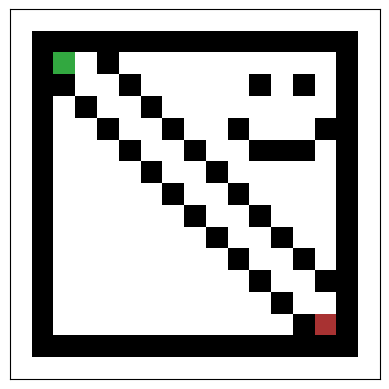

In [102]:
g5 = draw_grid('/content/drive/MyDrive/Ece-Ntua/Lab_AI/Exercise_1/5.5.png')

Οι δύο αλγόριθμοι συμπεριφέρονται με τον ίδιο τρόπο γιατί από κάθε κατάσταση υπάρχει μοναδική μετάβαση.

In [104]:
pf5 = pathfinder(g5.S, g5.F, g5, c = lambda x, y: 1, h = lambda x, y: euclidean)   # A* algrorithm
g5.draw_map(pf5.get_path())
pf5.vis.show_gif()

TypeError: unsupported operand type(s) for +: 'int' and 'function'

In [105]:
pf5 = pathfinder(g5.S, g5.F, g5, c = lambda x, y: 1, h = lambda x, y: 0)   # Dijkstra
pf5.vis.show_gif()